# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from IPython.display import display as d

%matplotlib inline

# renamed df to df_user_item for more clarity
df_user_item = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df_user_item['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
print("Shape of df_user_item:", df_user_item.shape)
d(df_user_item.head(2))
print("\nShape of df_content:", df_content.shape)
d(df_content.head(2))

Shape of df_user_item: (45993, 3)


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b



Shape of df_content: (1056, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

,mean,std,min,25%,50%,75%,max
interaction_stats,8.930847,16.802267,1.0,1.0,3.0,9.0,364.0


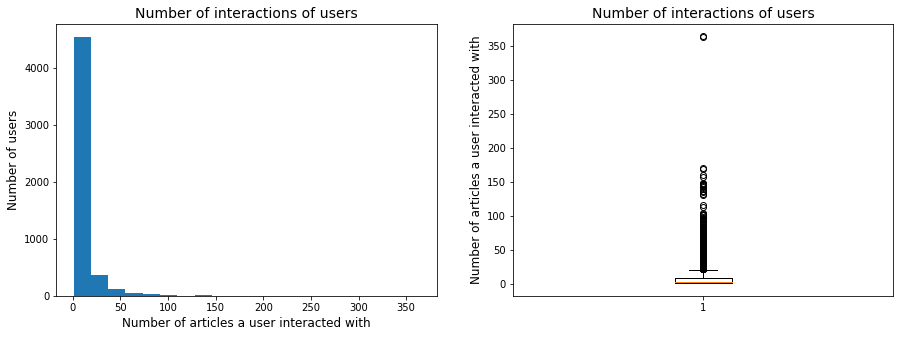

In [2]:
interact_num_articles = df_user_item[df_user_item.email.notnull()].groupby(["email"])["article_id"].count().values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(interact_num_articles, bins=20);
plt.title("Number of interactions of users", size=14);
plt.xlabel("Number of articles a user interacted with", size=12);
plt.ylabel("Number of users", size=12);
plt.subplot(1, 2, 2)
plt.boxplot(interact_num_articles);
plt.title("Number of interactions of users", size=14);
plt.ylabel("Number of articles a user interacted with", size=12);

descriptive_info = pd.DataFrame(df_user_item.groupby(["email"])["title"].count().describe())
descriptive_info.columns = ["interaction_stats"]
d(descriptive_info[1:].T)

On average the users interact with 8.9 articles. As we also have some users with many more interactions, up to 364, the median is much lower than the average at only 3 article interactions per user.

In [3]:
 # 50% of individuals interact with ____ number of articles or fewer.
median_val = descriptive_info["interaction_stats"]["50%"] 
 # The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = descriptive_info["interaction_stats"]["max"] 

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [4]:
# Find and explore duplicate articles
print("Number of unique article_id values:", df_content.article_id.unique().shape[0])
print("Number of rows in df_content dataset:", df_content.shape[0])

Number of unique article_id values: 1051
Number of rows in df_content dataset: 1056


=> Unequal number of unique article IDs and rows in df_content

In [5]:
duplicates = df_content[df_content.article_id.duplicated()]["article_id"].values
print(f"Duplicate articles:\n - IDs: {duplicates}\n - Data:")
d(df_content[df_content.article_id.isin(duplicates)].sort_values(by=["article_id"]))

Duplicate articles:
 - IDs: [ 50 221 398 577 232]
 - Data:


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [6]:
# Remove any rows that have the same article_id - only keep the first
print("df_content shape before removing duplicates:", df_content.shape)
df_content.drop_duplicates(subset=["article_id"], keep="first", inplace=True)
print("df_content shape after removing duplicates:", df_content.shape)

df_content shape before removing duplicates: (1056, 5)
df_content shape after removing duplicates: (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
print(f"""The df_user_item data has {df_user_item.email.isnull().sum()} NaN entries in the email column. \
Based on the given solution below those NaNs are not deleted.""")

The df_user_item data has 17 NaN entries in the email column. Based on the given solution below those NaNs are not deleted.


In [8]:
unique_articles = df_user_item.article_id.unique().shape[0] # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.unique().shape[0] # The number of unique articles on the IBM platform
unique_users = df_user_item[df_user_item.email.notnull()].email.unique().shape[0] # The number of unique users
user_article_interactions = df_user_item.shape[0] # The number of user-article interactions
print("unique_articles:", unique_articles, "\ntotal_articles:", total_articles, 
      "\nunique_users:", unique_users, "\nuser_article_interactions:", user_article_interactions)

unique_articles: 714 
total_articles: 1051 
unique_users: 5148 
user_article_interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
 # The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df_user_item.groupby(["article_id"])["title"].count().idxmax())
 # The most viewed article in the dataset was viewed how many times?
max_views = df_user_item.groupby(["article_id"])["title"].count().max() 
print("most_viewed_article_id:", most_viewed_article_id, "\nmax_views:", max_views)

most_viewed_article_id: 1429.0 
max_views: 937


In [10]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df_user_item['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df_user_item['email']
df_user_item['user_id'] = email_encoded

# show header
d(df_user_item.head(3))

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
def get_top_articles(n, df=df_user_item):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = [df[df.article_id == float(idx)]["title"].unique()[0] for idx in get_top_article_ids(n, df)]
    
    return top_articles # Return the top article titles from df (not df_content)


def get_top_article_ids(n, df=df_user_item):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    top_articles = df.groupby(["article_id"]).count()["title"].sort_values(ascending=False).index[:n].tolist()
    top_articles = [str(top_art) for top_art in top_articles]
    
    return top_articles # Return the top article ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df[df.user_id.notnull()].groupby(["user_id", "article_id"]).count().unstack()
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df_user_item)

In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    '''
    
    # compute similarity of each user to the provided user
    similarity = pd.DataFrame(np.dot(user_item, user_item.loc[user_id, :]))
    similarity.index = user_item.index
    similarity.columns = ["similarity"]
    # sort by similarity
    similarity = similarity.sort_values(by="similarity", ascending=False)
    # create list of just the ids
    similarity_ids = similarity.index
    # remove the own user's id
    most_similar_users = similarity_ids[similarity_ids != user_id].tolist()
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df_user_item):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    article_names = df[df.article_id.isin(article_ids)]["title"].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].unstack().columns.tolist()
    article_ids = [str(art_id) for art_id in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    recs = []
    similar_users = find_similar_users(user_id)
    for user in similar_users:
        recs.extend(get_user_articles(user)[0])
        if len(recs) >= m:
            break
    
    return recs[:10] # return your recommendations for this user_id    

In [20]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['time series prediction using recurrent neural networks (lstms)',
 'deep learning with tensorflow course by big data university',
 'tensorflow quick tips',
 'sector correlations shiny app',
 'new shiny cheat sheet and video tutorial',
 'introduction to market basket analysis in\xa0python',
 'tidyverse practice: mapping large european cities',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'python for loops explained (python for data science basics #5)',
 'introducing ibm watson studio ']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
def get_top_sorted_users(user_id, df=df_user_item, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    neighbors_df = pd.DataFrame({"neighbor_id": user_item.index, 
                  "similarity": np.dot(user_item, user_item.loc[user_id,:]),
                  "num_interactions": df_user_item.groupby(["user_id"])["article_id"].count().values})
    
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id].sort_values(by=["similarity", "num_interactions"], 
                                                                             ascending=False)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    recs = []
    rec_names = []
    similar_users = get_top_sorted_users(user_id)["neighbor_id"].values.tolist()
    
    for user in similar_users:
        recs.extend(get_user_articles(user)[0])
        rec_names.extend(get_user_articles(user)[1])
        
        if len(recs) >= m:
            break
    
    return recs[:m], rec_names[:m]

In [23]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '232.0', '302.0', '336.0', '362.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'ibm watson facebook posts for 2015', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'apache spark lab, part 3: machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [24]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0]["neighbor_id"] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]["neighbor_id"] # Find the 10th most similar user to user 131

In [25]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

>*For a new user there are no past interactions, which is why the similarity to other users can't be calculated. So the User-User based Collaborative Filtering methods are not applicable.
For this reason one way would be to only make knowledge/rank based recommendations, using get_top_article_ids() / get_top_articles().  
Content based recommendations would be a possibility to use new articles for recommendations.*

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [26]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(n=10) 

In [27]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [28]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [29]:
# quick look at the matrix
d(user_item_matrix.shape)
d(user_item_matrix.head(2))

(5149, 714)

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [30]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False, compute_uv=True) 
print(f"Shapes:\nu:\t{u.shape}\ns:\t{s.shape}\nvt:\t{vt.shape}")

Shapes:
u:	(5149, 714)
s:	(714,)
vt:	(714, 714)


>*In the lesson the user-item-matrix contained ratings of users. Since no user rated all the items, the matrix was sparse. For standard SVD a sparse input matrix with missing values does not work, which is why Simon Funk came up with FunkSVD to be able to use SVD on sparse data as well.  
Also the user-item-matrix in the lesson contained rating values in the range of 1 to 10. The user-item-matrix in this exercise however contains only 0 or 1, indicating only if the user interacted with an article or not.*

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

#### Function *acc_vs_latent_feats()*
<a id='acc_vs_latent_feats'></a>
The provided code was modified and put into a function for more generalized use:

In [31]:
def acc_vs_latent_feats(df_usr_itm, usr_itm_matrix, users):
    """Plot accuracy depending on the number of latent features
    INPUT:
    df_usr_itm: dataframe containing the user-item-interactions, base for user_item_matrix
    usr_itm_matrix: a user-item matrix of the given dataframe df_usr_itm
    users: array of user IDs to make a prediction for
        
    OUTPUT:
    num_latent_feats: array of number of latent features that have been evaluated
    acc: array of accuracy values for given array of number of latent features
    """

    num_latent_feats = np.arange(10,700+10,20)
    sum_errs = []
    u, s, vt = np.linalg.svd(usr_itm_matrix, full_matrices=False, compute_uv=True)
    
    idx_pred = [idx - 1 for idx in users]
    
    for k in num_latent_feats:
        # restructure with k latent features and only selected users
        u_new = u[idx_pred, :k]
        s_new = np.diag(s[:k])
        vt_new = vt[:k, :]
        
        # take dot product
        pred = np.around(np.dot(np.dot(u_new, s_new), vt_new))
        
        # compute error for each prediction to actual value
        diffs = np.subtract(usr_itm_matrix.iloc[idx_pred, :], pred)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)

    acc = 1 - np.array(sum_errs) / df_usr_itm[df_usr_itm.user_id.isin(users)].shape[0] 
    
    plt.plot(num_latent_feats, acc);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    plt.grid(color="lightgrey")
    plt.show()
    
    return num_latent_feats, acc

In [32]:
# adapted version of acc_vs_latent_feats for further evaluation
def acc_vs_latent_feats_diag(df_usr_itm, usr_itm_matrix, users, lf=[10, 100, 350, 600]):
    """Plot accuracy depending on the number of latent features (10, 100, 350, 600) and plotting raw estimations
    INPUT:
    df_usr_itm: dataframe containing the user-item-interactions, base for user_item_matrix
    usr_itm_matrix: a user-item matrix of the given dataframe df_usr_itm
    users: array of user IDs to make a prediction for
    lf: array with four numbers of latent features to evaluate
    
    OUTPUT:
    num_latent_feats: array of number of latent features that have been evaluated
    acc: array of accuracy values for given array of number of latent features
    """
    
    num_latent_feats = lf
    sum_errs = []
    u, s, vt = np.linalg.svd(usr_itm_matrix, full_matrices=False, compute_uv=True)
    
    idx_pred = [idx - 1 for idx in users]
    i = 1
    print(f"Raw prediction value and accuracy results for {len(users)} users:")
    
    plt.subplots(figsize=(16, 3))
    for k in num_latent_feats:
        # restructure with k latent features and only selected users
        u_new = u[idx_pred, :k]
        s_new = np.diag(s[:k])
        vt_new = vt[:k, :]

        # take dot product
        pred = (np.dot(np.dot(u_new, s_new), vt_new))
        
        pred_long = np.array(pred).reshape(-1, 1)
        plt.subplot(1, 4, i)
        plt.scatter(range(pred_long.shape[0]), pred_long, color="lightblue", edgecolors="darkblue")
        plt.hlines(0.5, 0, pred_long.shape[0])
        plt.xlabel("User-Article-Pair")
        if i == 1:
            plt.ylabel("Predicted Label")
        plt.yticks([-0.5, 0, 0.5, 1, 1.5], ["", 0, 0.5, 1, ""])
        plt.title("No. of latent features: " + str(k))
        i += 1
    
        pred = np.around(pred)
        # compute error for each prediction to actual value
        diffs = np.subtract(usr_itm_matrix.iloc[idx_pred, :], pred)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)

    plt.show()
    acc = 1 - np.array(sum_errs) / df_usr_itm[df_usr_itm.user_id.isin(users)].shape[0] 
    
    plt.figure(figsize=(16, 2.5))
    plt.plot(num_latent_feats, acc);
    plt.scatter(num_latent_feats, acc, color="k");
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.yticks(np.arange(0.2, 1.4, 0.2))
    plt.title('Accuracy vs. Number of Latent Features');
    plt.grid(color="lightgrey")
    plt.show()
    
    print(("Explanation of plots:\n"
    "On the top row you can see the raw prediction values for the given users, "
    "depending on the number of latent features used ({} users times {} movies results in {} "
    "user-article-pairs to predict). As can be seen, with more latent features the predictions are "
    "closer to 0 or 1, before rounding to 0 or 1, representing more confident predictions. "
    "\nThe bottom plot shows the accuracy of the predictions depending on the number of latent features used, "
    "according to the top row plots.").format(len(users), 
                                                  user_item_matrix.shape[1], 
                                                  len(users) * user_item_matrix.shape[1],))
    
    return num_latent_feats, acc

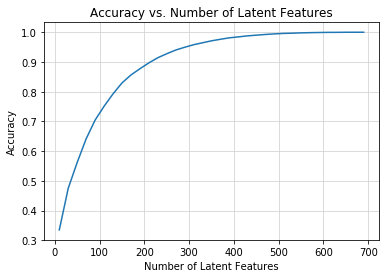

In [33]:
num_feats_all, acc_all = acc_vs_latent_feats(df_user_item, user_item_matrix, user_item_matrix.index.values);

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [34]:
df_train = df_user_item.head(40000)
df_test = df_user_item.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.get_level_values(1)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [35]:
# Answers to questions below:
users_trained = [usr for usr in test_idx if usr in user_item_train.index.values]
movies_trained = [mvie for mvie in test_arts if mvie in user_item_train.columns.get_level_values(1)]

print(f"1) Users, that were in the training set: {len(users_trained)}")
print(f"2) Users with no prediction: {len(test_idx) - len(users_trained)}")
print(f"3) Movies, that were in the training set: {len(movies_trained)}")
print(f"4) Movies with no prediction: {len(test_arts) - len(movies_trained)}")

1) Users, that were in the training set: 20
2) Users with no prediction: 662
3) Movies, that were in the training set: 574
4) Movies with no prediction: 0


In [36]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [37]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False, compute_uv=True)
print(f"Shapes:\nu:\t{u_train.shape}\ns:\t{s_train.shape}\nvt:\t{vt_train.shape}")

Shapes:
u:	(4487, 714)
s:	(714,)
vt:	(714, 714)


In [38]:
print(f"Users for whom a prediction is possible (i.e. they are also in df_train):\n{users_trained}")

Users for whom a prediction is possible (i.e. they are also in df_train):
[2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968, 3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487]


The code from question 3 was modified and put into a function [*acc_vs_latent_feats()*](#Function-acc_vs_latent_feats()) for more generalized use:

Evaluation of prediction for users in user_item_test:


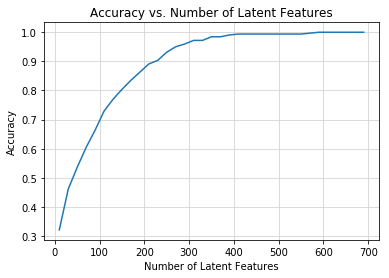

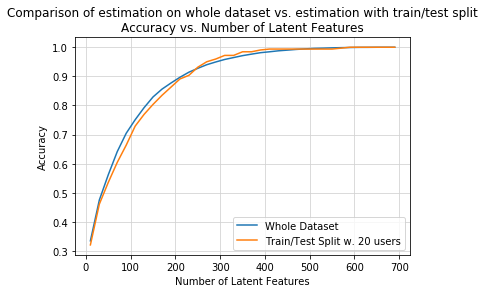

In [39]:
print("Evaluation of prediction for users in user_item_test:")
num_feats_test, acc_test = acc_vs_latent_feats(df_test, user_item_train, users_trained)

# compare accuracy of train/test evaluation with all
plt.plot(num_feats_all, acc_all)
plt.plot(num_feats_test, acc_test)
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Comparison of estimation on whole dataset vs. estimation with train/test split\nAccuracy vs. Number of Latent Features');
plt.legend(["Whole Dataset", "Train/Test Split w. 20 users"]);
plt.grid(color="lightgrey")

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

>*The evaluation of the number of latent features used to make recommendations shows, that around 200 latent features are necessary to achieve an accuracy of 90% in this offline test. Based on this result it seems reasonable to use around 200 latent features, which is a reduction of over 70% and thus improves the performance of the algorithm.  
Both cases, training on the training set and only predicting 20 users from the test set, as well as training on the full dataset and making recommendations for all users in the data showed similar behaviour. The plots above and the two following cells below illustrate this result.*
*[Some stats](#Diffences-in-data-between-complete-dataset-and-20-users-from-test-data:) on the dataset also show, that the 20 users in the test dataset differ from the average user, as in having more than average interactions with articles. This may influence the quality of recommendations for those users.  
It may also be good to test another metric like F1-Score to consider unbalanced data with either a majority of ones or zeros.*

>*One other interesting point to show is that the goal for this usecase is just to recommend if an article would be interesting to the reader or not, a 0 or 1 estimation and not a continous value prediction like in the previous lessons.  
With less latent features this leads to less confident estimations, as the predicted values may be close to 0.5 and then get rounded to 0 or 1. So values close to 0.5 are very sensitive to slight algorithm improvements and with more features the confidence grows as the plots below demonstrate. With close to 700 latent features the raw estimation values already are very close to 0 or 1.*

>*Starting off with offline validation using available data is a good possibility to check if your recommendation algorithms are working. However evaluating the algorithm on just 20 users, which also tend to have provided more data than the average user, is not enough for a solid conclusion.   
To get a better understanding of the real world performance, it would be good practice to follow up on those first results by A/B testing the algorithms with new, real user inputs.  
For this users could be grouped for example based on cookie information or random assignment to deliver recommendations based on the new algorithm to one group compared to the other group receiving recommendations from the old algorithm. One metric to evaluate the difference could be to count the number of recommended articles that the user actually interacted with compared to the number of recommended articles, since we want to predict articles with as much relevance to the user as possible. For new users we should use rank-based recommendations to get the first few datapoints and cope with the cold-start problem.*

Raw prediction value and accuracy results for 20 users:


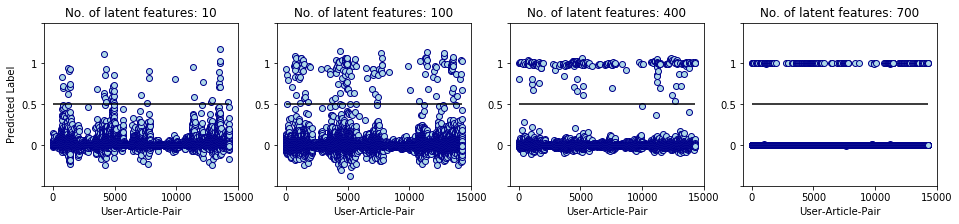

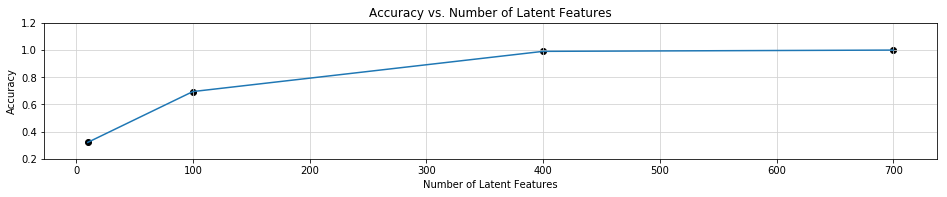

Explanation of plots:
On the top row you can see the raw prediction values for the given users, depending on the number of latent features used (20 users times 714 movies results in 14280 user-article-pairs to predict). As can be seen, with more latent features the predictions are closer to 0 or 1, before rounding to 0 or 1, representing more confident predictions. 
The bottom plot shows the accuracy of the predictions depending on the number of latent features used, according to the top row plots.


In [40]:
acc_vs_latent_feats_diag(df_test, user_item_train, users_trained, [10, 100, 400, 700]);

Raw prediction value and accuracy results for 5149 users:


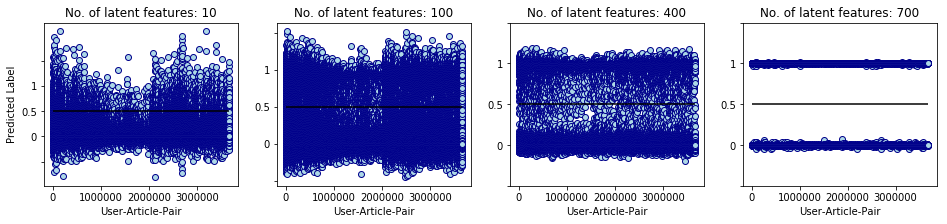

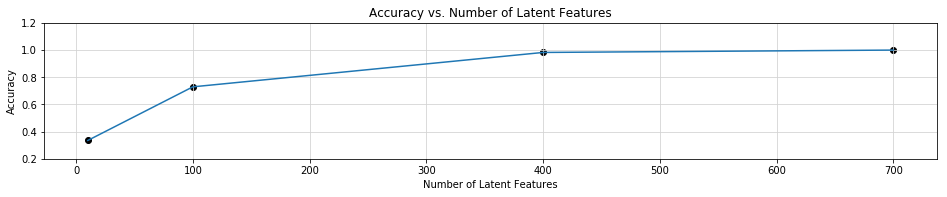

Explanation of plots:
On the top row you can see the raw prediction values for the given users, depending on the number of latent features used (5149 users times 714 movies results in 3676386 user-article-pairs to predict). As can be seen, with more latent features the predictions are closer to 0 or 1, before rounding to 0 or 1, representing more confident predictions. 
The bottom plot shows the accuracy of the predictions depending on the number of latent features used, according to the top row plots.


In [41]:
acc_vs_latent_feats_diag(df_user_item, user_item_matrix, user_item_matrix.index.values, [10, 100, 400, 700]);

#### Diffences in data between complete dataset and 20 users from test data:

       mean       std  min  25%  50%  75%    max
0  6.541464  9.990112  1.0  1.0  3.0  7.0  135.0


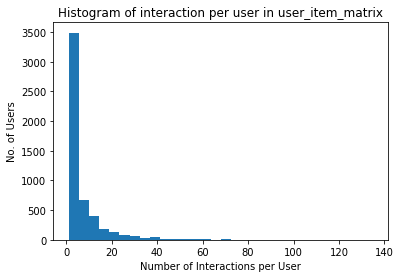

Mean/Median number of user interactions:
... of all users in whole dataset: 6.5 / 3.0
... of the 20 users to predict in train data: 12.8 / 12.0
... of the 20 users to predict in test data: 10.9 / 5.0


In [42]:
print(pd.DataFrame(user_item_matrix.sum(axis=1).describe()[1:]).T)
plt.hist(user_item_matrix.sum(axis=1), bins=30);
plt.xlabel('Number of Interactions per User');
plt.ylabel('No. of Users');
plt.title('Histogram of interaction per user in user_item_matrix');
plt.show()

print("Mean/Median number of user interactions:")
print("... of all users in whole dataset:", 
      round(user_item_matrix.sum(axis=1).mean(), 1), "/",
      round(user_item_matrix.sum(axis=1).median(), 1)
     )
print("... of the 20 users to predict in train data:", 
      round(user_item_train[user_item_train.index.isin(users_trained)].sum(axis=1).mean(), 1), "/",
      round(user_item_train[user_item_train.index.isin(users_trained)].sum(axis=1).median(), 1)
     )
print("... of the 20 users to predict in test data:", 
      round(user_item_test[user_item_test.index.isin(users_trained)].sum(axis=1).mean(), 1), "/",
      round(user_item_test[user_item_test.index.isin(users_trained)].sum(axis=1).median(), 1)
     )

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

#### Augment df_content with length of text features for content based recommendation

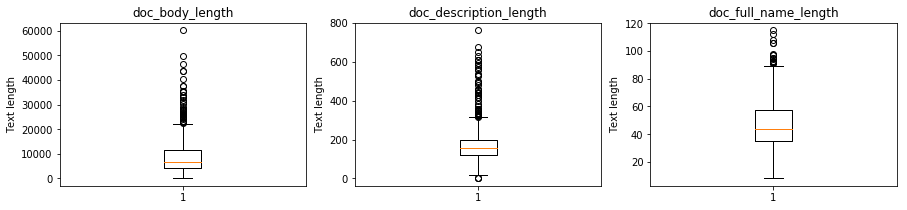

In [43]:
for col in df_content.columns[:3]:
    df_content[col + "_length"] = df_content[col].apply(lambda x: len(x) if not(np.isreal(x)) else 0)

data = df_content.iloc[:, -3:]
plt.figure(figsize=(15, 3))
for i in range(data.shape[1]):
    plt.subplot(1, 3, i+1)
    plt.boxplot(data.values[:, i])
    plt.title(data.columns[i])
    plt.ylabel("Text length")

In [44]:
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id,doc_body_length,doc_description_length,doc_full_name_length
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,4828,70,58
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,21271,198,59
